In [2]:
# basic maths capabilities
import math

# more advanced maths capabilities
import numpy
import numpy.random as rnd
import networkx as nx
# timing how long things take
import time

# analysis and presentation
import pandas
# graphing and animation tools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
from matplotlib import animation
import seaborn as sns

# use high-performance SVG graphics in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

/cs/home/tt24/.local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
class HCgraph(nx.Graph):
    def __init__(self, household_size, community_size, number_of_communities):
        self._household_size = household_size
        self._community_size = community_size
        self._number_of_communities = number_of_communities
        G = self.create_community(community_size)
        for i in range(1, number_of_communities):
            C = self.create_community(community_size-1)
            G = self.add_community(G, C)
        last_community = len(G.nodes())/household_size-1
        for i in range(0, household_size*(community_size-1)/household_size):
            G.add_edge(self.get_random_node(last_community), self.get_random_node(i))
        nx.Graph.__init__(self,G)

    def create_household(self):
        G=nx.complete_graph(self._household_size)
        return G

    def create_community(self, community_size):
        households = []
        for i in range(community_size):
            H =self.create_household()
            households.insert(0, H)
        G = households[0]
        for i in range(1, len(households)):
            G = nx.disjoint_union(G, households[i])
        for i in range(len(households)-1):
            for j in range(i+1, len(households)):
                G.add_edge(self.get_random_node(i), self.get_random_node(j))
        return G

    def add_community(self, G, community):
        last_community = len(G.nodes())/self._household_size-1
        G=nx.disjoint_union(G, community)
        for i in range(last_community+1, last_community+len(community.nodes())/self._household_size+1):
            G.add_edge(self.get_random_node(last_community), self.get_random_node(i))
        return G

    def get_random_node(self, household_number):
        low = self._household_size*household_number
        return rnd.randint(low, low+self._household_size-1)
    
    def get_nodes_in_community(self, s_node):
        intervals = {}
        household_number = s_node/self._household_size
        s_comm = s_node/((self._community_size-1)*self._household_size)
        s_from = s_comm*((self._community_size-1)*self._household_size)
        s_to = s_from+self._household_size*self._community_size-1
        #deal with overflow
        num_of_nodes = len(self.nodes())
        if s_to>num_of_nodes:
            s_to = s_to-num_of_nodes
        intervals[0] = [s_from, s_to]
        if household_number%(self._community_size-1)==0:
            if s_comm==0:
                s_from1 = num_of_nodes-self._household_size
                s_to1 = num_of_nodes-1
            else:
                s_comm1 = s_comm-1
                s_from1 = s_comm1*((self._community_size-1)*self._household_size)
                s_to1 = s_from1+self._household_size*self._community_size-1
            intervals[1] = [s_from1, s_to1]
        return intervals

In [3]:
class GraphWithDynamics(HCgraph):
    '''A NetworkX undirected network with an associated dynamics. This
    class combines two sets of entwined functionality: a network, and
    the dynamical process being studied. This is the abstract base class
    for studying different kinds of dynamics.'''

    # keys for node and edge attributes
    OCCUPIED = 'occupied'     # edge has been used to transfer infection or not
    DYNAMICAL_STATE = 'seir'   # dynamical state of a node

    def __init__( self, household_size=0, community_size=0, number_of_communities=0, g = None ):
        '''Create a graph, optionally with nodes and edges copied from
        the graph given.
        
        g: graph to copy (optional)'''
        if household_size!=0 and community_size!=0 and number_of_communities!=0:
            HCgraph.__init__(self, household_size, community_size, number_of_communities)
        else:
            nx.Graph.__init__(self, g)
            if g is not None:
                self.copy_from(g)
        
    def copy_from( self, g ):
        '''Copy the nodes and edges from another graph into us.
        
        g: the graph to copy from
        returns: the graph'''
        
        # copy in nodes and edges from source network
        self.add_nodes_from(g.nodes_iter())
        self.add_edges_from(g.edges_iter())
        
        # remove self-loops
        es = self.selfloop_edges()
        self.remove_edges_from(es)
        
        return self
    
    def remove_all_nodes( self ):
        '''Remove all nodes and edges from the graph.'''
        self.remove_nodes_from(self.nodes())

    def at_equilibrium( self, t ):
        '''Test whether the model is an equilibrium. The default runs for
        20000 steps and then stops.
        
        t: the current simulation timestep
        returns: True if we're done'''
        return (t >= 20000)

    def before( self ):
        '''Placeholder to be run ahead of simulation, Defaults does nothing.'''
        pass

    def after( self ):
        '''Placeholder to be run after simulation, Defaults does nothing.'''
        pass
    
    def _dynamics( self ):
        '''Internal function defining the way the dynamics works.

        returns: a dict of properties'''
        raise NotYetImplementedError('_dynamics()')
        
    def dynamics( self ):
        '''Run a number of iterations of the model over the network. The
        default doesn't add anything to the basic parameters captured 
        
        returns: a dict of properties'''
        return self._dynamics()

    def skeletonise( self ):
        '''Remove unoccupied edges from the network.
        
        returns: the network with unoccupied edges removed'''
        
#         # find all unoccupied edges
#         edges = []
#         for n in self.nodes_iter():
#             for (np, m, data) in self.edges_iter(n, data = True):
#                 if (self.OCCUPIED not in data.keys()) or (data[self.OCCUPIED] != True):
#                     # edge is unoccupied, mark it to be removed
#                     # (safe because there are no parallel edges)
#                     edges.insert(0, (n, m))
                    
#         # remove them
#         self.remove_edges_from(edges)
        return self
    
    def populations( self ):
        '''Return a count of the number of nodes in each dynamical state.
        
        returns: a dict'''
        pops = dict()
        for n in self.nodes_iter():
            s = self.node[n][self.DYNAMICAL_STATE]
            if s not in pops.keys():
                pops[s] = 1
            else:
                pops[s] = pops[s] + 1
        return pops

In [4]:
class GraphWithSynchronousDynamics(GraphWithDynamics):
    '''A graph with a dynamics that runs synchronously,
    applying the dynamics to each node in the network.'''
        
    def __init__( self, household_size=0, community_size=0, number_of_communities=0, g = None ):
        '''Create a graph, optionally with nodes and edges copied from
        the graph given.
        
        g: graph to copy (optional)'''
        GraphWithDynamics.__init__(self,household_size, community_size, number_of_communities, g)
        
    def model( self, n ):
        '''The dynamics function that's run over the network. This
        is a placeholder to be re-defined by sub-classes.
        
        n: the node being simulated
        returns: the number of events that happened in this timestep'''
        raise NotYetImplementedError('model()')
    
    def _dynamics_step( self, t ):
        '''Run a single step of the model over the network.
        
        t: timestep being simulated
        returns: the number of dynamic events that happened in this timestep'''
        events = 0
        for i in self.node.keys():
            events = events + self.model(i)
        return events

    def _dynamics( self ):
        '''Synchronous dynamics. We apply _dynamics_step() at each timestep
        and then check for completion using at_equilibrium().
        
        returns: a dict of simulation properties'''
        rc = dict()

        rc['start_time'] = time.clock()
        self.before()
        t = 0
        events = 0
        eventDist = dict()
        timestepEvents = 0
        while True:
            # run a step
            nev = self._dynamics_step(t)
            if nev > 0:
                events = events + nev
                timestepEvents = timestepEvents + 1
                eventDist[t] = nev
        
            # test for termination
            if self.at_equilibrium(t):
                break
            
            t = t + 1
        self.after()
        rc['end_time'] = time.clock()
        
        # return the simulation-level results
        rc['elapsed_time'] = rc['end_time'] - rc['start_time']
        rc['timesteps'] = t
        rc['events'] = events
        rc['event_distribution'] = eventDist
        rc['timesteps_with_events'] = timestepEvents
        return rc

In [5]:
class SEIRSynchronousDynamics(GraphWithSynchronousDynamics):
    '''A graph with a particular SEIR dynamics. We use probabilities
    to express infection and recovery per timestep, and run the system
    using synchronous dynamics.'''
    
    # the possible dynamics states of a node for SEIR dynamics
    SUSCEPTIBLE = 'S'
    EXPOSED = 'E'
    INFECTED = 'I'
    REMOVED = 'R'
    
    # list of infected nodes, the sites of all the dynamics
    _infected = []
    
    # list of exposed nodes
    _exposed = []
    
    # list of dynamic states captured during a simulation
    _states = dict()
    
    _populations = dict()
    
    def __init__( self, household_size=0, community_size=0, number_of_communities=0,
                 beta = 0.0, gamma = 1.0, pInfected = 0.0, eta = 1.0, delta = 0.0, epsilon = 1.0, zeta = 1.0, g = None ):
        '''Generate a graph with dynamics for the given parameters.
        
        beta: infection probability (defaults to 0.0)
        gamma: probability of recovery (defaults to 1.0)
        pInfected: initial infection probability (defaults to 0.0)
        g: the graph to copy from (optional)'''
        GraphWithSynchronousDynamics.__init__(self,household_size, community_size, number_of_communities, g)
        self._beta = beta
        self._gamma = gamma
        self._pInfected = pInfected
        self._eta = eta
        self._delta = delta
        self._epsilon = epsilon
        self._zeta = zeta
            
    def before( self ):
        '''Seed the network with infected nodes, and mark all edges
        as unoccupied by the dynamics.'''
        self._infected = []       # in case we re-run from a dirty intermediate state
        self._exposed = []
        for n in self.node.keys():
            if numpy.random.random() <= self._pInfected:
                self._infected.insert(0, n)
                self.node[n][self.DYNAMICAL_STATE] = self.INFECTED
            else:
                self.node[n][self.DYNAMICAL_STATE] = self.SUSCEPTIBLE
        for (n, m, data) in self.edges_iter(data = True):
            data[self.OCCUPIED] = False

    def _dynamics_step( self, t ):
        '''Optimised per-step dynamics that only runs the dynamics at infected
        nodes, since they're the only places where state changes originate. At the
        end of each timestep we re-build the infected node list.
        
        t: timestep being simulated
        returns: the number of events that happened in this timestep'''
        events = 0
        
        # run model dynamics on all infected nodes
        for n in self._infected:
            events = events + self.model(n)
    
        # re-build the infected list if we need to
        if events > 0:
            self._infected = [ n for n in self._infected if self.node[n][self.DYNAMICAL_STATE] == self.INFECTED ]

        events1 = 0
            
        for n in self._exposed:
            events1 = events1 + self.end_latent(n)
            
        # re-build the exposed list if we need to
        if events1 > 0:
            self._exposed = [ n for n in self._exposed if self.node[n][self.DYNAMICAL_STATE] == self.EXPOSED ]
        
        events = events+events1
        # if the state has changed, capture it
        if (t == 0) or (events > 0):
            ss = dict()
            for n in self.nodes_iter():
                ss[n] = self.node[n][self.DYNAMICAL_STATE]
            self._states[t] = ss
            self._populations[t] = self.populations()
            
        return events
    
    def model( self, n ):
        '''Apply the SEIR dynamics to node n. From the re-definition of _dynamics_step()
        we already know this node is infected.

        n: the node
        returns: the number of changes made'''
        events = 0
        
        # infect susceptible neighbours with probability beta
        for (_, m, data) in self.edges_iter(n, data = True):
            if self.node[m][self.DYNAMICAL_STATE] == self.SUSCEPTIBLE:
                if numpy.random.random() <= self._beta:
                    events = events + 1
                    
                    # infect the node
                    self.node[m][self.DYNAMICAL_STATE] = self.EXPOSED
                    self._exposed.insert(0, m)
                        
                    # label the edge we traversed as occupied
                    data[self.OCCUPIED] = True
    
        # recover with probability gamma
        if numpy.random.random() <= self._gamma:
            # recover the node
            events = events + 1
            self.node[n][self.DYNAMICAL_STATE] = self.REMOVED
              
        return events
    
    def end_latent( self, n ):
        '''Apply the SEIR dynamics to node n. From the re-definition of _dynamics_step()
        we already know this node is exposed.

        n: the node
        returns: the number of changes made'''
        events = 0

        # end latent perioud with probability eta
        if numpy.random.random() <= self._eta:
            # make the node infected
            events = events + 1
            self.node[n][self.DYNAMICAL_STATE] = self.INFECTED
            self._infected.insert(0, n)
        return events
    
    def at_equilibrium( self, t ):
        '''SEIR dynamics is at equilibrium if there are no more
        infected nodes left in the network or if we've exceeded
        the default simulation length.
        
        returns: True if the model has stopped'''
        if t >= 20000:
            return True
        else:
            return ((len(self._infected) == 0) and len(self._exposed)==0)
            
    def dynamics( self ):
        '''Returns statistics of outbreak sizes. This skeletonises the
        network, so it can't have any further dynamics run on it.
        
        returns: a dict of statistical properties'''
        
        # run the basic dynamics
        rc = self._dynamics()
        
        # compute the limits and means
        cs = sorted(nx.connected_components(self.skeletonise()), key = len, reverse = True)
        max_outbreak_size = len(cs[0])
        max_outbreak_proportion = (max_outbreak_size + 0.0) / self.order()
        mean_outbreak_size = numpy.mean([ len(c) for c in cs ])
        
        # add parameters and metrics for this simulation run
        rc['pInfected' ] = self._pInfected,
        rc['gamma'] = self._gamma,
        rc['beta'] = self._beta,
        rc['eta'] = self._eta,
        rc['N'] = self.order(),
        rc['mean_outbreak_size'] = mean_outbreak_size,
        rc['max_outbreak_size'] = max_outbreak_size,
        rc['max_outbreak_proportion'] = max_outbreak_proportion
        rc['evolution'] = self._states
        rc['populations'] = self._populations
        return rc

In [6]:
class SEIDRSynchronousDynamics(GraphWithSynchronousDynamics):
    '''A graph with a particular SEIDR dynamics. We use probabilities
    to express infection and recovery per timestep, and run the system
    using synchronous dynamics.'''
    
    # the possible dynamics states of a node for SEIR dynamics
    SUSCEPTIBLE = 'S'
    EXPOSED = 'E'
    INFECTED = 'I'
    RECOVERED = 'R'
    DEAD = 'D'
    REMOVED = 'DR'
    
    # list of infected nodes, the sites of all the dynamics
    _infected = []
    
    # list of exposed nodes
    _exposed = []
    
    # list of dead nodes
    _dead = []
    
    # list of edges
    _edges = []
    
    # list of dynamic edges captured during a simulation
    _edges_time = dict()
    
    # list of dynamic states captured during a simulation
    _states = dict()
    
    _populations = dict()
    
    _exposed_from_infected = 0
    _exposed_from_dead = 0
    
    def __init__( self,household_size=0, community_size=0, number_of_communities=0,
                 beta = 0.0, gamma = 1.0, pInfected = 0.0, eta = 1.0, 
                 delta = 0.0, epsilon = 1.0, zeta = 1.0, g = None, rewire_degree = 0, pExposed = 0.0):
        '''Generate a graph with dynamics for the given parameters.
        
        beta: infection probability (defaults to 0.0)
        gamma: probability of recovery (defaults to 1.0)
        pInfected: initial infection probability (defaults to 0.0)
        g: the graph to copy from (optional)'''
        GraphWithSynchronousDynamics.__init__(self,household_size, community_size, number_of_communities, g)
        self._household_size = household_size
        self._community_size = community_size
        self._number_of_communities = number_of_communities
        self._beta = beta
        self._gamma = gamma
        self._pInfected = pInfected
        self._pExposed = pExposed
        self._eta = eta
        self._delta = delta
        self._epsilon = epsilon
        self._zeta = zeta
        self._rewire_degree = rewire_degree
            
    def before( self ):
        '''Seed the network with infected and exposed nodes, and mark all edges
        as unoccupied by the dynamics.'''
        self._infected = []       # in case we re-run from a dirty intermediate state
        self._exposed = []
        self._dead = []
        self._exposed_from_infected = 0
        self._exposed_from_dead = 0
        for n in self.node.keys():
            if numpy.random.random() <= self._pInfected:
                self._infected.insert(0, n)
                self.node[n][self.DYNAMICAL_STATE] = self.INFECTED
            else:
                self.node[n][self.DYNAMICAL_STATE] = self.SUSCEPTIBLE
        for (n, m, data) in self.edges_iter(data = True):
            data[self.OCCUPIED] = False
        self._edges = self.edges()
            
        
    def rewire(self, start_node, end_node, dead_node):
        for i in range(start_node, end_node+1):
            if (dead_node, i) not in self._edges and (i, dead_node) not in self._edges and dead_node !=i and self.node[i][self.DYNAMICAL_STATE] != self.REMOVED:
                self.add_edge(dead_node, i)
                self._edges.insert(0, (dead_node, i))
                
    def rewire1(self, dead_node):
        nodes_num = len(self.nodes())
        num = int(self._rewire_degree*nodes_num/100)
        for i in range(0, num):
            random_node = randint(0,nodes_num-1)
            if (dead_node, random_node) not in self._edges and (random_node, dead_node) not in self._edges and dead_node !=random_node and self.node[random_node][self.DYNAMICAL_STATE] != self.REMOVED:
                self.add_edge(dead_node, random_node)
                self._edges.insert(0, (dead_node, random_node))
            


    def _dynamics_step( self, t ):
        '''Optimised per-step dynamics that only runs the dynamics at infected
        nodes, since they're the only places where state changes originate. At the
        end of each timestep we re-build the infected node list.
        
        t: timestep being simulated
        returns: the number of events that happened in this timestep'''
        events = 0
        
        # run model dynamics on all infected nodes
        for n in self._infected:
            events = events + self.model(n)
            
            
        # re-build the infected list if we need to
        if events > 0:
            self._infected = [ n for n in self._infected if self.node[n][self.DYNAMICAL_STATE] == self.INFECTED ]
            
        events1 = 0
            
        # run model1 dynamics on all dead nodes
        for n in self._dead:
            events1 = events1 + self.model1(n)
            
        # re-build the infected list if we need to
        if events1 > 0:
            self._dead = [ n for n in self._dead if self.node[n][self.DYNAMICAL_STATE] == self.DEAD ]
            
#         # re-build the infected list if we need to
#         if events > 0:
#             self._infected = [ n for n in self._infected if self.node[n][self.DYNAMICAL_STATE] == self.INFECTED ]
            
#         # re-build the exposed list if we need to
#         if events > 0 and not self._exposed:
#             self._exposed = [ n for n in self._exposed if self.node[n][self.DYNAMICAL_STATE] == self.EXPOSED ]
            
        events2 = 0
    
        for n in self._exposed:
            events2 = events2 + self.end_latent(n)
            
        # re-build the exposed list if we need to
        if events2 > 0:
            self._exposed = [ n for n in self._exposed if self.node[n][self.DYNAMICAL_STATE] == self.EXPOSED ]
        
        events = events+events1+events2
        # if the state has changed, capture it
        if (t == 0) or (events > 0):
            ss = dict()
            for n in self.nodes_iter():
                ss[n] = self.node[n][self.DYNAMICAL_STATE]
            self._states[t] = ss
            self._populations[t] = self.populations()
        self._edges_time[t] = list(self._edges)
            
        return events
    
    def model1( self, n ):
        '''Apply the SEIDR dynamics to (dead) node n.
        n: the node
        returns: the number of changes made'''
        events = 0
        
        # infect susceptible neighbours with probability delta
        for (_, m, data) in self.edges_iter(n, data = True):
            if self.node[m][self.DYNAMICAL_STATE] == self.SUSCEPTIBLE:
                if numpy.random.random() <= self._delta:
                    events = events + 1
                    
                    # infect the node
                    self.node[m][self.DYNAMICAL_STATE] = self.EXPOSED
                    self._exposed_from_dead = self._exposed_from_dead + 1
                    self._exposed.insert(0, m)
                        
                    # label the edge we traversed as occupied
                    data[self.OCCUPIED] = True
    
        # node moves to the R compartment with probability zeta
        if numpy.random.random() <= self._zeta:
            events = events + 1
            self.node[n][self.DYNAMICAL_STATE] = self.REMOVED
              
        return events
    
    def model( self, n ):
        '''Apply the SEIR dynamics to node n. From the re-definition of _dynamics_step()
        we already know this node is infected.
        n: the node
        returns: the number of changes made'''
        events = 0

        # infect susceptible neighbours with probability beta
        for (_, m, data) in self.edges_iter(n, data = True):
            if self.node[m][self.DYNAMICAL_STATE] == self.SUSCEPTIBLE:
                if numpy.random.random() <= self._beta:
                    events = events + 1

                    # infect the node
                    self.node[m][self.DYNAMICAL_STATE] = self.EXPOSED
                    self._exposed_from_infected = self._exposed_from_infected + 1
                    self._exposed.insert(0, m)

                    # label the edge we traversed as occupied
                    data[self.OCCUPIED] = True

        # recover with probability gamma
        if numpy.random.random() <= self._gamma:
            # recover the node
            events = events + 1
            if numpy.random.random() <= self._epsilon:
                self.node[n][self.DYNAMICAL_STATE] = self.RECOVERED
            else:
                self.node[n][self.DYNAMICAL_STATE] = self.DEAD
                self._dead.insert(0, n)
                # if an HCgraph rewire nodes to connect people in the same community with the dead person
                if self._household_size!=0 and self._community_size!=0 and self._number_of_communities!=0:
                    intervals = self.get_nodes_in_community(n)
                    for index in range(len(intervals)):
                        self.rewire(intervals[index][0], intervals[index][1], n)
                else:
                    self.rewire1(n)

        return events
    
    def end_latent( self, n ):
        '''Apply the SEIR dynamics to node n. From the re-definition of _dynamics_step()
        we already know this node is exposed.
        n: the node
        returns: the number of changes made'''
        events = 0

        # end latent period with probability eta
        if numpy.random.random() <= self._eta:
            # make the node infected
            events = events + 1
            self.node[n][self.DYNAMICAL_STATE] = self.INFECTED
            self._infected.insert(0, n)
        return events
    
    def at_equilibrium( self, t ):
        '''SEIR dynamics is at equilibrium if there are no more
        infected nodes left in the network or if we've exceeded
        the default simulation length.
        
        returns: True if the model has stopped'''
        if t >= 20000:
            return True
        else:
            return((len(self._infected) == 0) and (len(self._exposed)==0) and (len(self._dead)==0))
            
    def dynamics( self ):
        '''Returns statistics of outbreak sizes. This skeletonises the
        network, so it can't have any further dynamics run on it.
        
        returns: a dict of statistical properties'''
        
        # run the basic dynamics
        rc = self._dynamics()
        
        # compute the limits and means
        cs = sorted(nx.connected_components(self.skeletonise()), key = len, reverse = True)
        max_outbreak_size = len(cs[0])
        max_outbreak_proportion = (max_outbreak_size + 0.0) / self.order()
        mean_outbreak_size = numpy.mean([ len(c) for c in cs ])
        
        # add parameters and metrics for this simulation run
        rc['pInfected' ] = self._pInfected,
        rc['pExposed'] = self._pExposed,
        rc['gamma'] = self._gamma,
        rc['beta'] = self._beta,
        rc['delta'] = self._delta,
        rc['epsilon'] = self._epsilon,
        rc['zeta'] = self._zeta,
        rc['eta'] = self._eta,
        rc['N'] = self.order(),
        rc['rewire_degree'] = self._rewire_degree,
        rc['mean_outbreak_size'] = mean_outbreak_size,
        rc['max_outbreak_size'] = max_outbreak_size,
        rc['max_outbreak_proportion'] = max_outbreak_proportion
        rc['evolution'] = self._states
        rc['edges'] = self._edges_time
        rc['populations'] = self._populations
        rc['exposed_from_infected'] = self._exposed_from_infected
        rc['exposed_from_dead'] = self._exposed_from_dead
        return rc

In [7]:
def show_changes(G, syn_dyn, pos=None):
    if pos==None:
        pos=nx.spring_layout(G) # positions for all nodes
    states = syn_dyn['evolution']
    if isinstance(G, SEIDRSynchronousDynamics):
        edges = syn_dyn['edges']
    susceptible_nodes_time = {}
    infected_nodes_time = {}
    exposed_nodes_time = {}
    removed_nodes_time = {}
    recovered_nodes_time = {}
    dead_nodes_time = {}
    changes = sorted(states.keys())
    for t in changes:
        susceptible_nodes = []
        infected_nodes = []
        exposed_nodes = []
        removed_nodes = []
        recovered_nodes = []
        dead_nodes = []
        for node in states[t]:
            if states[t][node]=='S':
                susceptible_nodes.insert(0, node)
            else:
                if states[t][node]=='I':
                    infected_nodes.insert(0, node)
                else:
                    if states[t][node]=='E':
                        exposed_nodes.insert(0, node)
                    else:
                        if states[t][node]=='R':
                            recovered_nodes.insert(0, node)
                        else:
                            if states[t][node]=='DR':
                                removed_nodes.insert(0, node)
                            else:
                                if states[t][node]=='D':
                                    dead_nodes.insert(0, node)
                                else: 
                                    print "Error"
        susceptible_nodes_time[t] = susceptible_nodes
        infected_nodes_time[t] = infected_nodes
        exposed_nodes_time[t] = exposed_nodes
        recovered_nodes_time[t] = recovered_nodes
        removed_nodes_time[t] = removed_nodes
        dead_nodes_time[t] = dead_nodes

    fig = plt.figure(figsize=(10,100))
    plot_number = 1
    node_size = 100
    alpha = 0.8
    for t in changes:
        plt.subplot(len(changes)+1,1,plot_number)
        plot_number=plot_number+1
        nx.draw_networkx_nodes(G,pos, ax=None,nodelist=susceptible_nodes_time[t],
                               node_color='y',
                               node_size=node_size,
                           alpha=alpha)
        nx.draw_networkx_nodes(G,pos,ax=None,nodelist=infected_nodes_time[t],
                               node_color='r',
                               node_size=node_size,
                           alpha=alpha)
        nx.draw_networkx_nodes(G,pos,ax=None,nodelist=exposed_nodes_time[t],
                               node_color='b',
                               node_size=node_size,
                           alpha=alpha)
        nx.draw_networkx_nodes(G,pos,ax=None,nodelist=recovered_nodes_time[t],
                               node_color='g',
                               node_size=node_size,
                           alpha=alpha)
        nx.draw_networkx_nodes(G,pos,ax=None,nodelist=removed_nodes_time[t],
                               node_color='grey',
                               node_size=node_size,
                           alpha=alpha)
        nx.draw_networkx_nodes(G,pos,ax=None,nodelist=dead_nodes_time[t],
                           node_color='black',
                           node_size=node_size,
                       alpha=alpha)
        if isinstance(G, SEIDRSynchronousDynamics):
            nx.draw_networkx_edges(G,pos,ax=None,edgelist =edges[t], width=1.0,alpha=0.5)
        else:
             nx.draw_networkx_edges(G,pos,ax=None, width=1.0,alpha=0.5)
        nx.draw_networkx_labels(G,pos)
        plt.title('t = {0}'.format(t))
        plt.axis('off')
    plt.show()

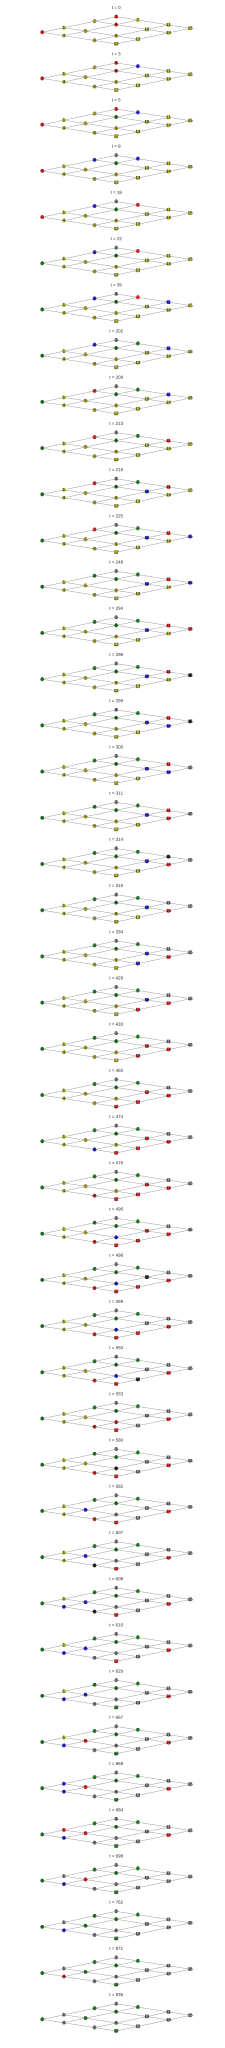

In [8]:
size = 4
# disease parameters
gamma = 0.01
beta = 0.02
delta = 0.5
epsilon = 0.3
zeta = 0.4
eta = 0.008

# what proportion of people are initially sick
pInfected = 0.1
G = nx.grid_2d_graph(size,size)
labels = {}
for l in G.nodes_iter():
    labels[l] = l[0]*size+l[1]

G = nx.relabel_nodes(G, labels)
syn = SEIDRSynchronousDynamics(pInfected = pInfected, beta = beta, gamma = gamma, eta = eta, delta = delta, epsilon = epsilon, zeta = zeta,
                             g = G)
syn_dyn = syn.dynamics()
show_changes(syn, syn_dyn, nx.spectral_layout(syn))

In [9]:
def animate_seir( g, dyn, fig, pos = None, **kwords ):
    '''Generate an animation function to animate the colours of nodes in
    a graph according to a completed simulation dynamics, putting the results
    in a figure that can be saved as a movie.
    
    g: the graph
    dyn: the simulation dynamics
    fig: the figure to plot into
    pos: (optional) the positions of the nodes (default is a spring layout)'''
    
    # manipulate the axes, since this isn't a data plot
    ax = fig.gca()
    ax.set_xlim([-0.2, 1.2])      # axes bounded around 1
    ax.set_ylim([-0.2, 1.2])
    ax.grid(False)                # no grid
    ax.get_xaxis().set_ticks([])  # no ticks on the axes
    ax.get_yaxis().set_ticks([])
    
    # if we're not given an explicit geometry, use the spring layout
    if pos == None:
        pos = nx.spring_layout(g, k = 4 / (2 * math.sqrt(g.order())))
        
    # generate node markers based on positions
    nodeMarkers = dict()
    for v in g.nodes_iter():
        circ = plt.Circle(pos[v], radius = 0.05)
        ax.add_patch(circ)
        nodeMarkers[v] = circ
        
    # grab the states of the dynamics
    states = dyn['evolution']
    changes = sorted(states.keys())
    
    # how many frames to generate
    if 'frames' not in kwords.keys():
        # if we're not given a number of frames, do all the change points
        kwords['frames'] = len(changes)
    else:
        # sanity check
        kwords['frames'] = max(kwords['frames'], len(changes))
    
    def colour_node_by_state( n, s ):
        '''Colour a node's marker according to its state.'''
        if s is g.SUSCEPTIBLE:
            nodeMarkers[n].set_facecolor('y')
        else:
            if s is g.INFECTED:
                nodeMarkers[n].set_facecolor('r')
            else:
                if s is g.RECOVERED:
                    nodeMarkers[n].set_facecolor('g')
                else:
                    nodeMarkers[n].set_facecolor('blue')
    
    def init():
        '''Generate the initial colours for nodes.'''
        for n in g.nodes_iter():
            colour_node_by_state(n, states[0][n])
                                 
    def frame( f ):
        '''Generate frame f by drawing in the node colours at
        the corresponding timestep.'''
        ss = states[changes[f]]
        for n in g.nodes_iter():
            colour_node_by_state(n, ss[n])
            
    # return the animation with the functions etc set up
    return animation.FuncAnimation(fig, frame, init_func = init, **kwords)

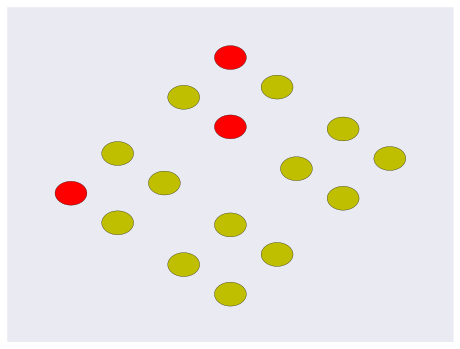

In [11]:
fig = plt.figure(figsize = (8, 6))
anim1 = animate_seir(syn, syn_dyn, fig, interval = 1000.0 / 30, pos=nx.spectral_layout(syn))

In [12]:
matplotlib.rcParams['animation.codec'] = 'gif'
anim1.save("seir-epidemic.gif")

33


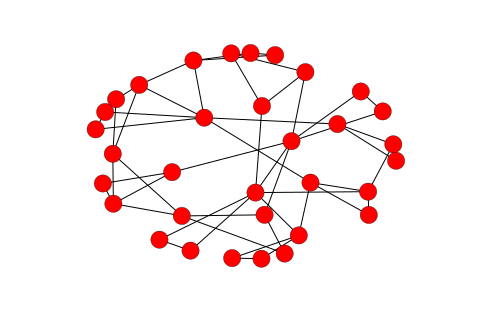

In [13]:
G = HCgraph(3,3,5)
plt.figure()
nx.draw(G)
print G.order()
plt.savefig('HCgraph.png')

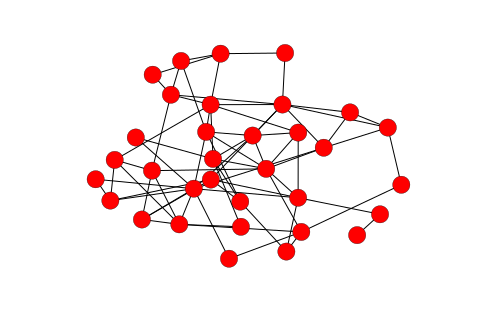

In [19]:
plt.figure()
nx.draw(nx.erdos_renyi_graph(33,0.16))
plt.savefig('ERgraph.png')